<a href="https://colab.research.google.com/github/YaronLi08/swe-social-economic-assip-2024/blob/main/swe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import radians, cos, sin, sqrt, atan2
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
swe = pd.read_csv('/content/gdrive/MyDrive/SWE/final_merged_data_3yrs_cleaned_v3.csv')

# Convert the date column to datetime format
swe['date'] = pd.to_datetime(swe['date'], errors='coerce')
swe.dropna(subset=['date'], inplace=True)  # Drop rows with invalid dates

# Set the 'date' column as the index
swe.set_index('date', inplace=True)

# Find the earliest and latest dates in the dataset
earliest_date = swe.index.min()
latest_date = swe.index.max()

# Print the date range
print(f"The dataset covers the period from {earliest_date} to {latest_date}.")

# Locations that the database covers
unique_locations = swe[['lat', 'lon']].drop_duplicates()
print(unique_locations)

print(swe.head())

The dataset covers the period from 2019-01-01 00:00:00 to 2022-12-31 00:00:00.
                  lat         lon
date                             
2020-11-25  37.192360 -118.939041
2020-11-25  40.398035 -106.605171
2020-11-25  37.428140 -106.623137
2020-11-25  38.490519 -106.335677
2020-11-25  40.295338 -111.258444
...               ...         ...
2021-01-15  42.696921 -120.798553
2021-01-15  34.860600 -111.608788
2020-05-02  40.739226 -110.620640
2020-12-03  37.006073 -106.272795
2019-01-13  36.682572 -118.427001

[243 rows x 2 columns]
                 lat         lon  SWE  Flag  swe_value  Unnamed: 0  \
date                                                                 
2020-11-25  37.19236 -118.939041  255   255        2.0      802331   
2020-10-18  37.19236 -118.939041    0   241        0.0      802293   
2020-09-21  37.19236 -118.939041    0   241        0.0      802266   
2022-09-01  37.19236 -118.939041    0   241        0.0       35648   
2019-10-03  37.19236 -118.939041   

In [ ]:
# Load the CSV file with datetime parsing
temp = pd.read_csv('/content/gdrive/MyDrive/SWE/river.csv', parse_dates=['datetime'])

# Set the datetime column as the index
temp.set_index('datetime', inplace=True)

# Convert the relevant column to numeric forcing errors to NaN
temp['211999_00060'] = pd.to_numeric(temp['211999_00060'], errors='coerce')

# Drop rows with NaN values in the numeric column
temp.dropna(subset=['211999_00060'], inplace=True)

# Resample to daily frequency and calculate the mean for the numeric column
river_daily = temp.resample('D').agg({'211999_00060': 'mean'})

# Save to a new CSV file
river_daily.to_csv('/content/gdrive/MyDrive/SWE/river_daily.csv')

# Display the resulting DataFrame
print(river_daily.head())

            211999_00060
datetime                
2020-07-15     17.761458
2020-07-16     16.320833
2020-07-17     20.661458
2020-07-18     20.628125
2020-07-19     19.723958


In [ ]:
# Reload SWE and River Flow datasets
swe = pd.read_csv('/content/gdrive/MyDrive/SWE/final_merged_data_3yrs_cleaned_v3.csv')
swe['date'] = pd.to_datetime(swe['date'], errors='coerce')
swe.dropna(subset=['date'], inplace=True)
swe.set_index('date', inplace=True)

river_daily = pd.read_csv('/content/gdrive/MyDrive/SWE/river_daily.csv')
river_daily['datetime'] = pd.to_datetime(river_daily['datetime'], errors='coerce')
river_daily.set_index('datetime', inplace=True)

# Ensure the index names are consistent
swe.index.name = 'datetime'
river_daily.index.name = 'datetime'

# Check date ranges
print("SWE DataFrame date range:", swe.index.min(), "to", swe.index.max())
print("River Flow DataFrame date range:", river_daily.index.min(), "to", river_daily.index.max())

# Filter both datasets to overlapping date range
start_date = max(swe.index.min(), river_daily.index.min())
end_date = min(swe.index.max(), river_daily.index.max())

# Remove duplicates if necessary
swe = swe.loc[~swe.index.duplicated(keep='first')]
river_daily = river_daily.loc[~river_daily.index.duplicated(keep='first')]

# Now apply the date range filtering
swe_location = swe.loc[start_date:end_date]
river_daily = river_daily.loc[start_date:end_date]

# Inspect column names
print("SWE DataFrame columns:", swe_location.columns)
print("River Flow DataFrame columns:", river_daily.columns)

# Rename columns for clarity
swe_location.rename(columns={'swe_value': 'swe'}, inplace=True)
river_daily.rename(columns={'211999_00060': 'river_flow'}, inplace=True)

# Merge the datasets on the datetime index
merged_df = pd.merge(swe_location, river_daily, left_index=True, right_index=True, how='inner')

# Drop rows with missing values in 'swe' and 'river_flow'
merged_df.dropna(subset=['swe', 'river_flow'], inplace=True)

# Print the merged DataFrame and check for missing values
print("Merged DataFrame shape:", merged_df.shape)
print("\nFirst few rows of merged DataFrame:")
print(merged_df.head())

print("\nMissing Values in Merged DataFrame:")
print(merged_df.isnull().sum())

SWE DataFrame date range: 2019-01-01 00:00:00 to 2022-12-31 00:00:00
River Flow DataFrame date range: 2020-07-15 00:00:00 to 2022-12-31 00:00:00
SWE DataFrame columns: Index(['lat', 'lon', 'SWE', 'Flag', 'swe_value', 'Unnamed: 0',
       'air_temperature_tmmn', 'potential_evapotranspiration',
       'mean_vapor_pressure_deficit', 'relative_humidity_rmax',
       'relative_humidity_rmin', 'precipitation_amount',
       'air_temperature_tmmx', 'wind_speed', 'elevation', 'slope', 'curvature',
       'aspect', 'eastness', 'northness'],
      dtype='object')
River Flow DataFrame columns: Index(['211999_00060'], dtype='object')
Merged DataFrame shape: (551, 21)

First few rows of merged DataFrame:
                 lat         lon  SWE  Flag  swe  Unnamed: 0  \
datetime                                                       
2020-07-15  37.19236 -118.939041    0   241  0.0      802198   
2021-11-11  37.19236 -118.939041    0   241  0.0      291219   
2020-09-29  37.19236 -118.939041    0   241

<ipython-input-5-94881945ddbc>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swe_location.rename(columns={'swe_value': 'swe'}, inplace=True)


In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of earth in kilometers
    return r * c

# Coordinates
lat_swe, lon_swe = 40.398035, -106.605171
lat_river, lon_river = 40.4816, -106.7769

# Calculate distance
distance_km = haversine(lon_swe, lat_swe, lon_river, lat_river)
print(f"Distance between locations: {distance_km:.2f} km")

# Assume a weight matrix where weight is inverse of distance
W = np.array([[1 / distance_km]])
print("Spatial Weight Matrix:\n", W)

# Add spatial lag: multiply SWE by the spatial weight matrix
merged_df['spatial_lag_swe'] = merged_df['swe'] * W[0, 0]
print("\nDataFrame with Spatial Lag:")
print(merged_df.head())

# Define the dependent variable (y) and independent variables (X)
y = merged_df['river_flow']
X = merged_df[['swe', 'spatial_lag_swe']]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

Distance between locations: 17.25 km
Spatial Weight Matrix:
 [[0.05797154]]

DataFrame with Spatial Lag:
                 lat         lon  SWE  Flag  swe  Unnamed: 0  \
datetime                                                       
2020-07-15  37.19236 -118.939041    0   241  0.0      802198   
2021-11-11  37.19236 -118.939041    0   241  0.0      291219   
2020-09-29  37.19236 -118.939041    0   241  0.0      802274   
2021-01-26  37.19236 -118.939041   32   241  6.6      290930   
2022-07-28  37.19236 -118.939041  255   255  0.0       35613   

            air_temperature_tmmn  potential_evapotranspiration  \
datetime                                                         
2020-07-15                 278.3                           1.7   
2021-11-11                 273.6                           1.5   
2020-09-29                 279.6                           3.0   
2021-01-26                 252.3                           3.1   
2022-07-28                 282.5                  

In [ ]:
X = sm.add_constant(merged_df[['swe', 'spatial_lag_swe']])
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          Variable       VIF
0            const  1.339358
1              swe       inf
2  spatial_lag_swe       inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[['swe', 'spatial_lag_swe']])

# Apply PCA
pca = PCA(n_components=1)  # Reduce to 1 component
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal component
merged_df['pca_component'] = X_pca

# Fit the model with PCA component
y = merged_df['river_flow']
X = sm.add_constant(merged_df[['pca_component']])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             river_flow   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     26.13
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           4.41e-07
Time:                        01:22:17   Log-Likelihood:                -3261.7
No. Observations:                 551   AIC:                             6527.
Df Residuals:                     549   BIC:                             6536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            39.2941      3.844     10.221

In [ ]:
# Prepare the data
X = merged_df[['swe', 'spatial_lag_swe']]
y = merged_df['river_flow']

# Apply Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

# Print coefficients
print("Ridge coefficients:", ridge.coef_)

Ridge coefficients: [-5.11482711 -0.29651442]


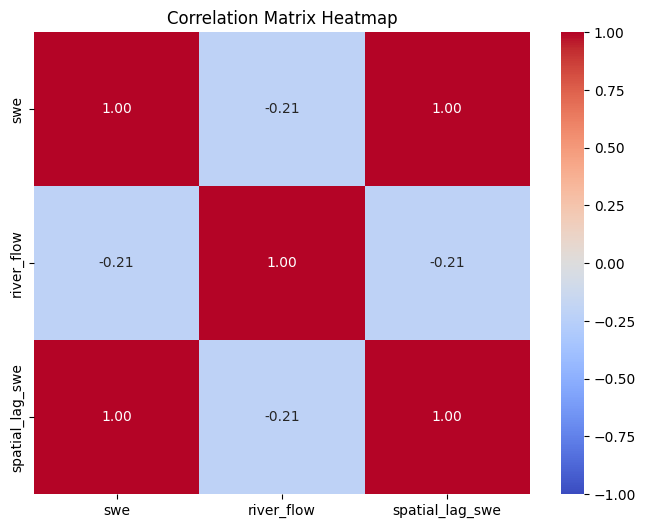

In [ ]:
# Compute the correlation matrix
corr_matrix = merged_df[['swe', 'river_flow', 'spatial_lag_swe']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

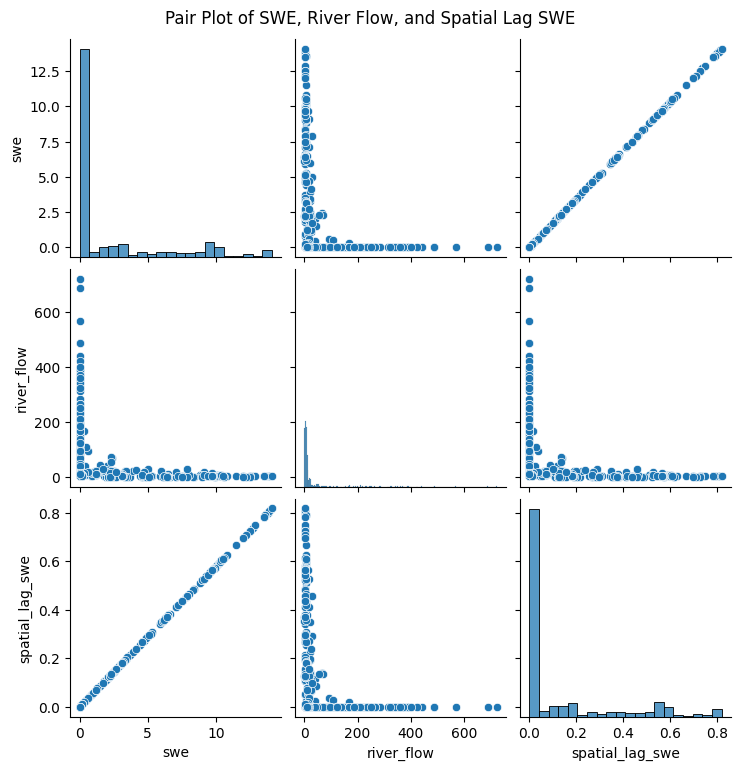

In [ ]:
# Create a pair plot
sns.pairplot(merged_df[['swe', 'river_flow', 'spatial_lag_swe']])
plt.suptitle('Pair Plot of SWE, River Flow, and Spatial Lag SWE', y=1.02)
plt.show()

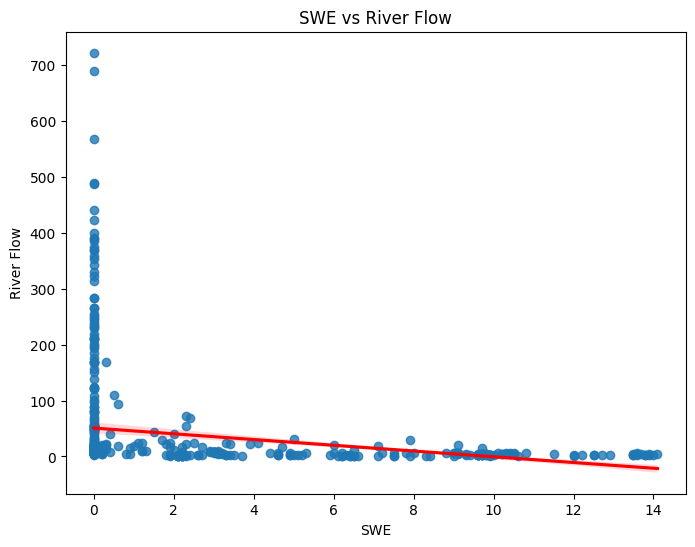

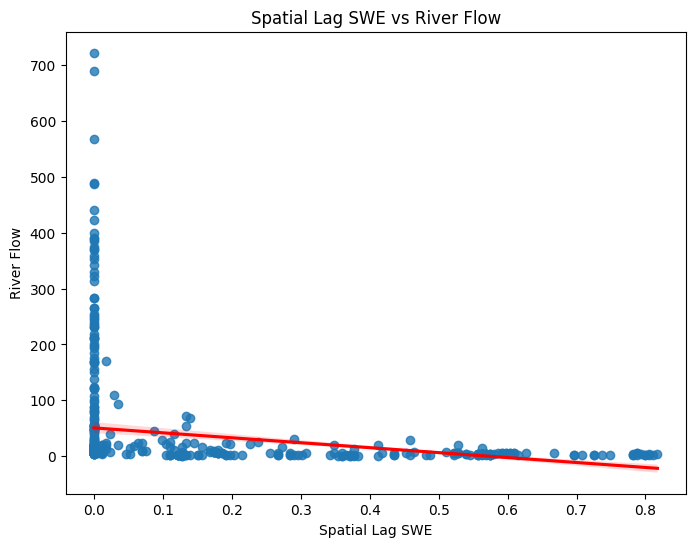

In [ ]:
# Scatter plot of SWE vs River Flow with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='swe', y='river_flow', data=merged_df, line_kws={"color":"red"})
plt.title('SWE vs River Flow')
plt.xlabel('SWE')
plt.ylabel('River Flow')
plt.show()

# Scatter plot of Spatial Lag SWE vs River Flow with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='spatial_lag_swe', y='river_flow', data=merged_df, line_kws={"color":"red"})
plt.title('Spatial Lag SWE vs River Flow')
plt.xlabel('Spatial Lag SWE')
plt.ylabel('River Flow')
plt.show()